# Orbit response 

In [1]:
import sys
import os
from os.path import join
import collections
from datetime import datetime
import importlib
import h5py
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import proplot as pplt

from tools.data import H5Reader

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

## Setup 

In [3]:
folder = 'Diagnostics/Data/Measurements/orbit_response/2022-05-11/'
filenames = os.listdir(folder)
filenames

['220511102740-orbit_response-QH11_VS22_Cam09.h5',
 '220511101859-orbit_response-QH13_VS14_Cam09.h5',
 '220511103208-orbit_response-QV12_VS30_Cam09.h5',
 '220511103314-orbit_response-QV10_VS30_Cam09.h5',
 '220511103347-orbit_response-QV09_VS30_Cam09.h5',
 '220511102845-orbit_response-QV09_VS22_Cam09.h5',
 '220511102918-orbit_response-QH08_VS22_Cam09.h5',
 '220511102707-orbit_response-QV12_VS22_Cam09.h5',
 '220511102117-orbit_response-QV09_VS14_Cam09.h5',
 '220511102812-orbit_response-QV10_VS22_Cam09.h5',
 '220511103420-orbit_response-QH08_VS30_Cam09.h5',
 '220511103453-orbit_response-QV07_VS30_Cam09.h5',
 '220511102627-orbit_response-QH13_VS22_Cam09.h5',
 '220511102011-orbit_response-QH11_VS14_Cam09.h5',
 '220511102150-orbit_response-QH08_VS14_Cam09.h5',
 '220511102044-orbit_response-QV10_VS14_Cam09.h5',
 '220511103241-orbit_response-QH11_VS30_Cam09.h5',
 '220511102951-orbit_response-QV07_VS22_Cam09.h5',
 '220511103128-orbit_response-QH13_VS30_Cam09.h5',
 '220511101939-orbit_response-Q

In [4]:
class DataFile(H5Reader):
    def __init__(self, filename, folder='.'):
        super().__init__(filename, folder)
        self.quad, self.screen, self.cam = self.filename.split('-')[-1].split('.h5')[0].split('_')
        self.screen_int = self.screen[-2:]
        self.quad_int = self.quad[-2:]
        self.cam_int = self.cam[-2:]

In [28]:
dfiles_by_screen = dict()
for filename in filenames:
    df = DataFile(filename, folder)
    if df.screen in dfiles_by_screen:
        dfiles_by_screen[df.screen].append(df)
    else:
        dfiles_by_screen[df.screen] = list()
    
for screen, dfiles in dfiles_by_screen.items():
    dfiles_by_screen[screen] = sorted(dfiles, key=lambda df: df.quad_int)
    
screens = sorted(list(dfiles_by_screen))
print('screens:', screens)

screens: ['VS14', 'VS22', 'VS30']


## Analysis

In [34]:
screen = 'VS14'
dfiles = dfiles_by_screen[screen]
quads = [df.quad for df in dfiles]
print('quads:', quads)

quads: ['QV07', 'QH08', 'QV09', 'QV10', 'QH11', 'QV12']


In [35]:
df = dfiles[0]
data = df.data
for field in data.dtype.fields.items():
    print(field)

('timestamp', (dtype('<f8'), 0))
('iteration', (dtype('int64'), 8))
('Cam09_ProfileY', (dtype(('<f4', (512,))), 16))
('Cam09_ProfileX', (dtype(('<f4', (612,))), 2064))
('QV07_CurrentRb', (dtype('<f8'), 4512))
('QV07_CurrentSet', (dtype('<f8'), 4520))


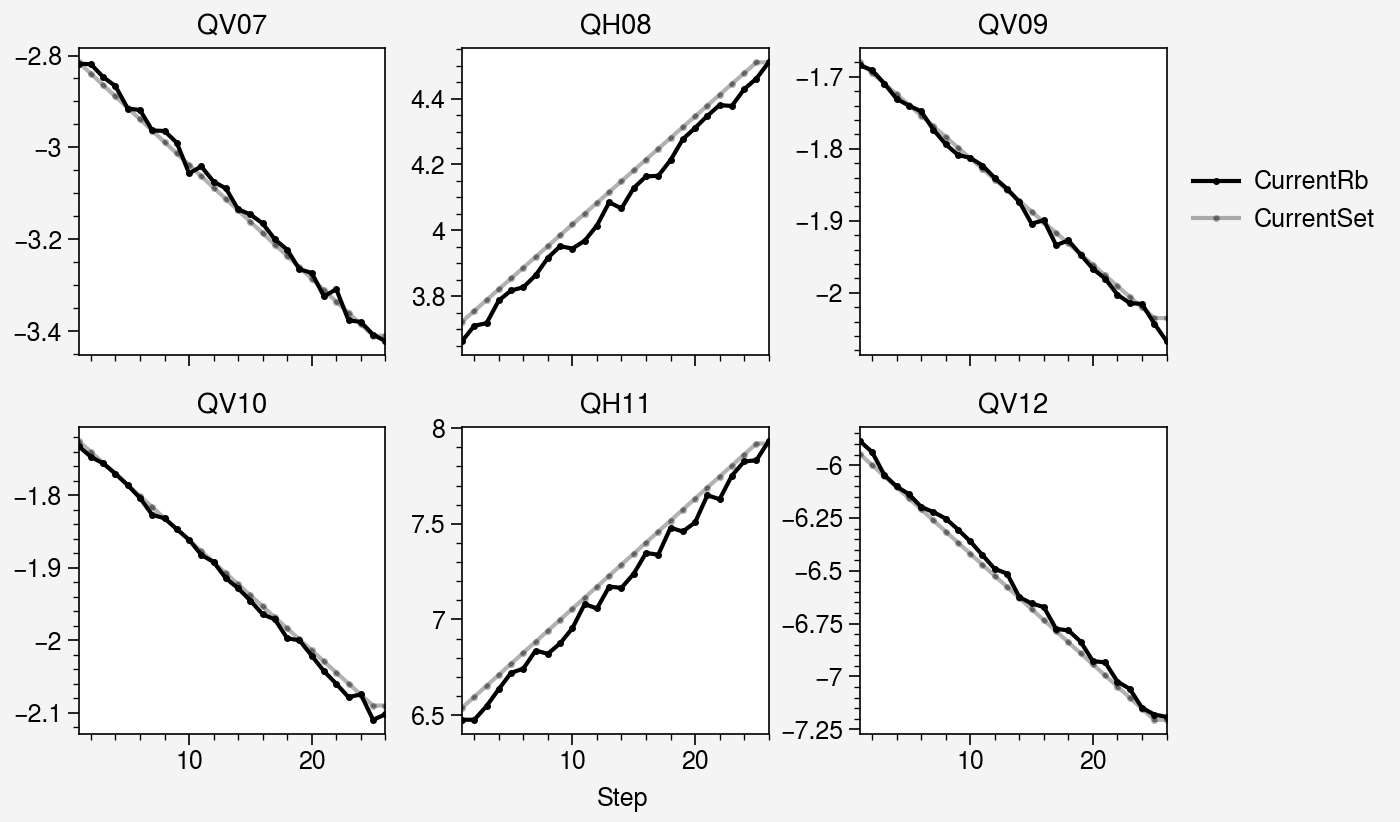

In [77]:
ncols = 3
nrows = int(np.ceil(len(dfiles) / ncols))    
istart = 1  # Ignore first data point.
kws = dict(marker='.', ms=3)

fig, axes = pplt.subplots(ncols=ncols, nrows=nrows, figwidth=7.0, sharey=False)
for ax, df in zip(axes, dfiles):
    name_rb = df.quad + '_CurrentRb'
    name_set = df.quad + '_CurrentSet'
    x = np.arange(istart, len(df.data))
    ax.plot(x, df.data[istart:, name_rb], color='black', label='CurrentRb', **kws)
    ax.plot(x, df.data[istart:, name_set], color='black', alpha=0.3, label='CurrentSet', **kws)
    ax.set_title(df.quad)
axes[0, -1].legend(loc='r', ncols=1, framealpha=0)
axes.format(xlabel='Step')